In [ ]:
#Run once per session
%load_ext autoreload
%autoreload 2
!pip install -q fastai==2.0.15

     |████████████████████████████████| 194kB 2.9MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 


# ITL fast.ai model

In [ ]:
from fastai.vision.all import *

In [ ]:
VERSION=10
ITL_DS_NAME = f'itl_dataset_v{VERSION}.zip'
ITL_DS_URL =  f'http://students.mimuw.edu.pl/~mt406390/machine_learning/' + ITL_DS_NAME
!wget $ITL_DS_URL
!unzip -qq $ITL_DS_NAME -d data/
path = Path('data')

--2020-10-07 05:26:59--  http://students.mimuw.edu.pl/~mt406390/machine_learning/itl_dataset_v10.zip
Resolving students.mimuw.edu.pl (students.mimuw.edu.pl)... 193.0.96.129, 2001:6a0:5001:1::3
Connecting to students.mimuw.edu.pl (students.mimuw.edu.pl)|193.0.96.129|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://students.mimuw.edu.pl/~mt406390/machine_learning/itl_dataset_v10.zip [following]
--2020-10-07 05:27:00--  https://students.mimuw.edu.pl/~mt406390/machine_learning/itl_dataset_v10.zip
Connecting to students.mimuw.edu.pl (students.mimuw.edu.pl)|193.0.96.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 782662455 (746M) [application/zip]
Saving to: ‘itl_dataset_v10.zip’

itl_dataset_v10.zip 100%[===================>] 746.40M  1.38MB/s    in 5m 25s  

2020-10-07 05:32:26 (2.30 MB/s) - ‘itl_dataset_v10.zip’ saved [782662455/782662455]



In [ ]:
path.ls()

(#4) [Path('data/annotations.json'),Path('data/operators.txt'),Path('data/output_proper'),Path('data/itl_labels.txt')]

In [ ]:
annots = json.load(path / 'annotations.json')
print(len(annots))
# FIXME (17 bboxes missing)
annots = list(filter(lambda x: len(x['exprs']) > 0, annots))

100008


In [ ]:
images = list(x['name'] for x in annots if len(x['exprs']) > 0)
print(len(images))
images[0]

100008


'eq0.png'

In [ ]:
op_lens = {'add': 2, 'sub': 2, 'mul': 2, 'frac': 2, 'sqrt': 1, 'int': 1, 'par': 1, 'fpar': 1, 'ffpar': 1, 'gpar': 1}

Next, we want to be able to quickly look up a corresponding image to it's label. We'll use a dictionary

In [ ]:
img2bbox = dict(zip(images, annots))

Great! Now let's build our `DataBlock`. We'll have two outputs, the bounding box itself and a label, with one input. For our `y`'s, we'll define some `getters`. The first of which will be `noop`, as we don't care about our initial image, and then we'll grab our label and bbox coordinates (we'll also define our `get_items`)

In [ ]:
def bbox_to_fastai(box):
    x, y, dx, dy = box
    return [x, y, x + dx, y + dy]

getters = [
    lambda o: path/'output_proper'/o, lambda o: list(map(bbox_to_fastai, img2bbox[o]['exprs'])),
    lambda o: len(img2bbox[o]['exprs']) * [img2bbox[o]['op']]
]

For our transforms, we'll use some of the ones we defined earlier

In [ ]:
item_tfms = []
batch_tfms = [Zoom(0.8, 1.2), Warp(0.15), Saturation(max_lighting=0.5)]

Why do we need a custom `get_images`? Because we want our **images** that came back to us, not the entire folder

In [ ]:
def get_train_imgs(noop):  return images

We'll now make our `DataBlock`. We want to adjust `n_inp` as we expect two outputs

In [ ]:
pascal = DataBlock(blocks=(ImageBlock(cls=PILImageBW), BBoxBlock, BBoxLblBlock),
                 splitter=RandomSplitter(0.1),
                 get_items=get_train_imgs, 
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

In [ ]:
BS = 64
dls = pascal.dataloaders(path/'train', bs=BS)
dls.c = len(set(x['op'] for x in annots))

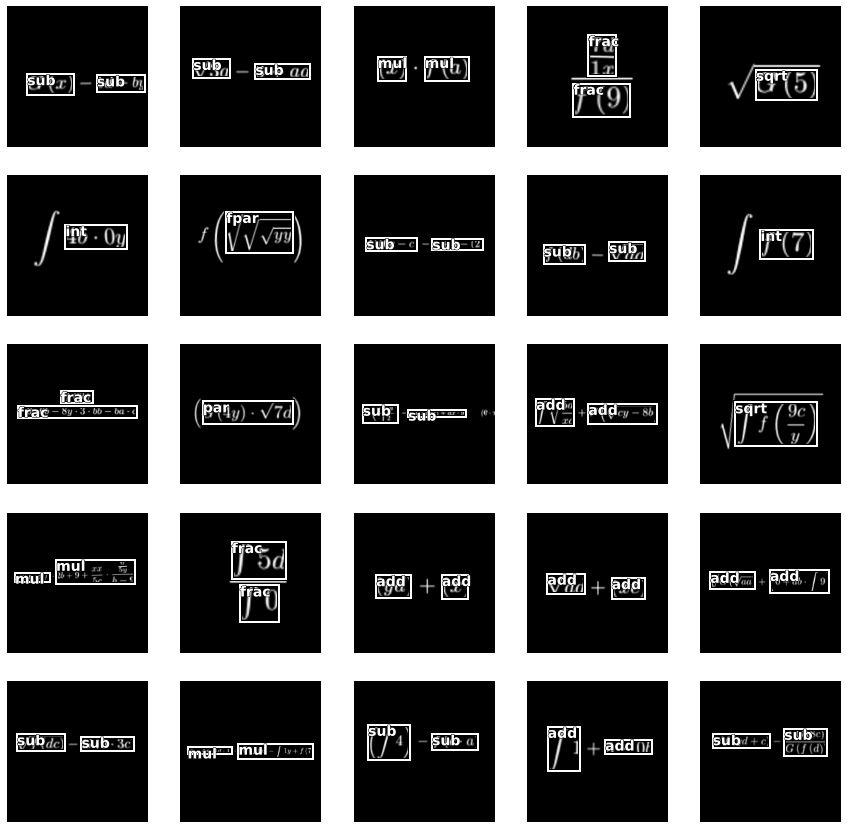

In [ ]:
dls.show_batch(max_n=25)

# ITL model

In [ ]:
POINTS_PER_BBOX = 4
N_BBOXES = 2
BBOXES = N_BBOXES * POINTS_PER_BBOX
CATS = dls.c
OUT = CATS + BBOXES

In [ ]:
head = nn.Sequential(
    nn.Conv2d(512, 128, 3, 2),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, OUT, 3, 1),
    # nn.BatchNorm2d(OUT),
    nn.Flatten()
)

bigger_shallow_head = nn.Sequential(
    nn.Conv2d(2048, 128, 3, 2),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, OUT, 3, 1),
    # nn.BatchNorm2d(OUT),
    nn.Flatten()
)

bigger_head = nn.Sequential(
    nn.Conv2d(512, 256, 3, 1),
    nn.BatchNorm2d(256),
    nn.Conv2d(256, 128, 3, 1),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, OUT, 3, 1),
    # nn.BatchNorm2d(OUT),
    nn.Flatten()
)

fc = create_head(1024, OUT)

cfg = cnn_config(n_in=1, custom_head=head)

In [ ]:
from torchvision.ops import box_iou

from pdb import set_trace

def encode_boxes(boxes_points):
    boxes_points = (boxes_points + 1) / 2
    x1, y1, x2, y2 = boxes_points[..., 0], boxes_points[..., 1], boxes_points[..., 2], boxes_points[..., 3]
    return torch.stack((x1, y1, torch.sqrt(x2 - x1), torch.sqrt(y2 - y1)), dim=-1)
    
def decode_boxes(boxes_lens):
    x, y, dx, dy = boxes_lens[..., 0], boxes_lens[..., 1], torch.square(boxes_lens[..., 2]), torch.square(boxes_lens[..., 3])
    boxes_points = torch.stack((x, y, x + dx, y + dy), dim=-1)
    return 2 * boxes_points - 1

class MseAndCrossEntropy(Module):
    def forward(self, pred, target_bboxes, target_cat):
        bboxes_preds = torch.sigmoid(pred[..., CATS:]).view((-1, N_BBOXES, POINTS_PER_BBOX))
        mask = (target_cat > 0)

        # set_trace()

        box_loss = F.mse_loss(bboxes_preds[mask], target_bboxes[mask])
        ce_loss = F.cross_entropy(pred[..., :CATS], target_cat[..., 0] - 1)
        return ce_loss + 50 * torch.sqrt(box_loss)

def ops_accuracy(pred, target_bboxes, target_cat):
    return accuracy(pred[..., :CATS], target_cat[..., 0] - 1)
    
def boxes_iou(pred, target_bboxes, target_cat):
    bboxes_preds = torch.sigmoid(pred[..., CATS:]).view((-1, N_BBOXES, POINTS_PER_BBOX))
    bboxes_decoded = decode_boxes(bboxes_preds)

    mask = (target_cat > 0)
    x, y = bboxes_decoded[mask], target_bboxes[mask]
    ious = torch.diagonal(box_iou(x, y))
    return ious.mean()


@log_args
class ITLLoss(BaseLoss):
    def __init__(self, *args, axis=-1, **kwargs):
        super().__init__(MseAndCrossEntropy, *args, axis=axis, **kwargs)

    def __call__(self, inp, targ, labels, **kwargs):
        targ_encoded = encode_boxes(targ)

        return self.func.__call__(inp, targ_encoded, labels)

    def decodes(self, x):
        categories, bboxes = x[...,:CATS], x[...,CATS:]
        bboxes = torch.sigmoid(bboxes)

        # Scaling back
        bboxes = decode_boxes(bboxes.view(-1, 2, 4))
        

        cats = (1 + categories.argmax(dim=-1)).unsqueeze(dim=-1)

        cats_stacked = torch.cat((cats, torch.zeros(cats.shape, dtype=torch.int64)), axis=-1)
        n = bboxes.shape[0]
        for i in range(n):
            current_cat = cats[i, 0]
            cat_lbl = dls.vocab[current_cat]
            if op_lens[cat_lbl] == 2:
                cats_stacked[i, 1] = cats_stacked[i, 0]
            else:
                bboxes[i, 1] = 0

        return bboxes, TensorMultiCategory(cats_stacked)


In [ ]:
learn = cnn_learner(dls, xse_resnext18, loss_func=ITLLoss(), pretrained=False, config=cfg,
                    metrics=[ops_accuracy, boxes_iou])
learn.fit_one_cycle(5, 0.001096)

epoch,train_loss,valid_loss,ops_accuracy,boxes_iou,time
0,2.666971,13.071040,0.230100,0.221293,05:31
1,1.548442,21.138260,0.417100,0.148882,05:29
2,1.092206,5.039180,0.943600,0.473576,05:29
3,0.716132,5.845424,0.807100,0.450772,05:30
4,0.576074,0.411018,0.999200,0.925026,05:30


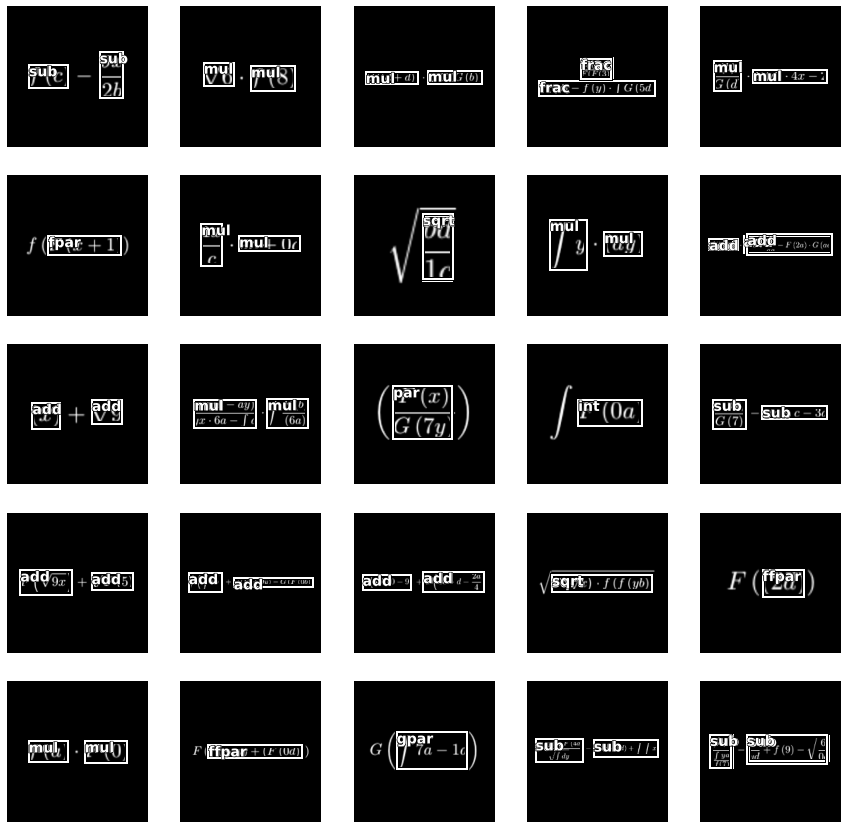

In [ ]:
learn.show_results(max_n=25)

In [ ]:
learn = cnn_learner(dls, xse_resnext18, loss_func=ITLLoss(), pretrained=False, config=cfg,
                    metrics=[ops_accuracy, boxes_iou])
learn.fit_one_cycle(10, 0.001585)

epoch,train_loss,valid_loss,ops_accuracy,boxes_iou,time
0,2.884017,6.668939,0.632200,0.296601,05:34
1,1.870987,2.623530,0.972300,0.577113,05:34
2,1.270378,14.237224,0.480000,0.185203,05:33
3,1.000398,13.014171,0.383100,0.213302,05:31
4,0.768849,12.587048,0.455600,0.280658,05:31
5,0.744104,3.964476,0.826700,0.548383,05:32
6,0.564906,0.580262,0.997900,0.881622,05:34
7,0.441673,0.379779,0.999800,0.918075,05:33
8,0.396789,0.328879,0.999800,0.934799,05:31
9,0.376880,0.285316,0.999800,0.943572,05:31


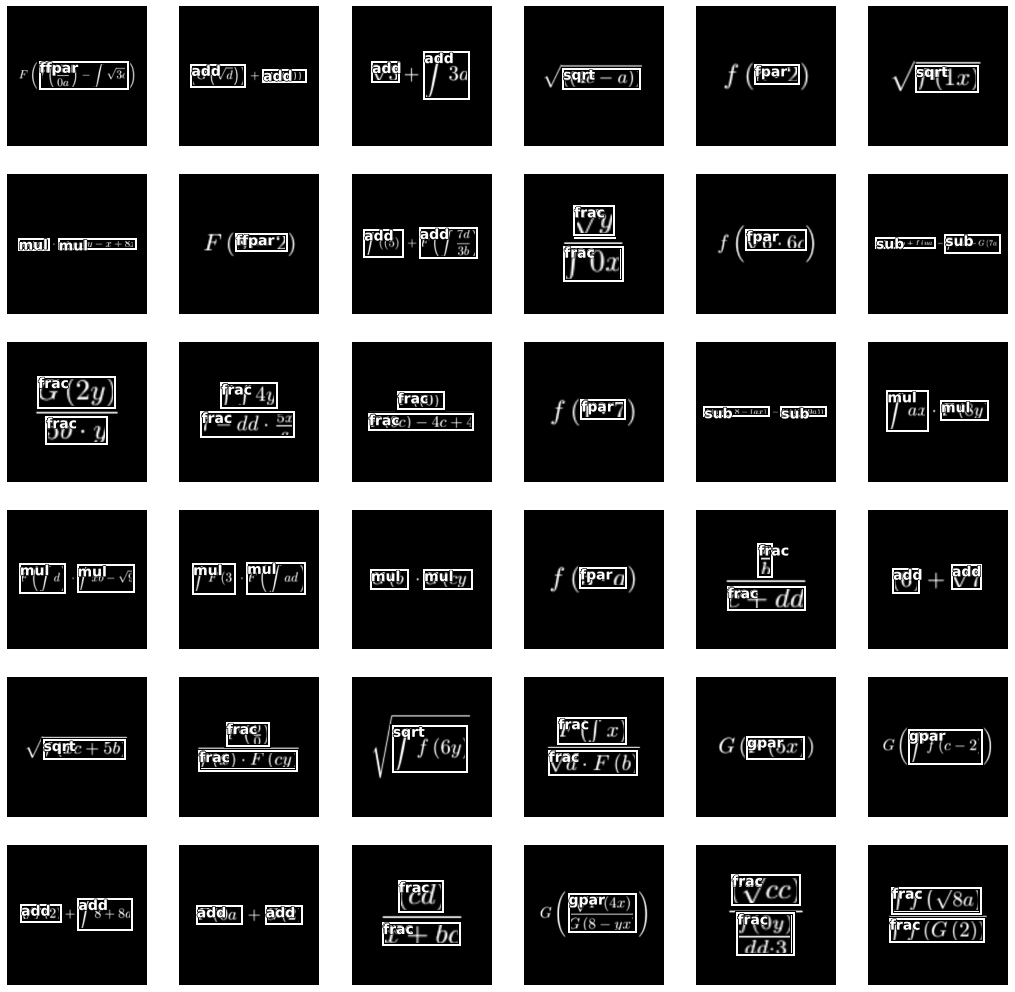

In [ ]:
learn.show_results(max_n=36)

In [ ]:
bigger_cnn_cfg = cnn_config(n_in=1, custom_head=bigger_shallow_head)

big_learn = cnn_learner(dls, xse_resnext50, loss_func=ITLLoss(), pretrained=False, config=bigger_cnn_cfg,
                    metrics=[ops_accuracy, boxes_iou])
big_learn.fit_one_cycle(20, 0.000912)
# big_learn.lr_find()

epoch,train_loss,valid_loss,ops_accuracy,boxes_iou,time
0,3.510915,3.184365,0.718400,0.542446,08:58
1,2.192353,2.465942,0.924000,0.568414,08:58
2,1.599306,6.509981,0.757600,0.400622,08:58
3,1.420006,9.356339,0.854600,0.273129,08:59
4,1.211073,32.493534,0.169700,0.154966,09:01
5,0.988952,11.986387,0.386200,0.272027,08:59
6,0.918669,32.225155,0.169700,0.172058,08:58
7,0.784252,6.957020,0.809800,0.364376,09:00
8,0.698523,30.933428,0.170000,0.161538,09:00
9,0.677936,5.080706,0.994300,0.474228,08:59


In [ ]:
learn = cnn_learner(dls, xse_resnext18, loss_func=ITLLoss(), pretrained=False, config=cfg,
                    metrics=[ops_accuracy, boxes_iou])
learn.fit_one_cycle(80, lr_max=0.000912)

epoch,train_loss,valid_loss,ops_accuracy,boxes_iou,time
0,11.226002,9.657714,0.363265,0.140478,00:28
1,8.595114,7.171036,0.419592,0.253725,00:27
2,7.214671,6.398857,0.444898,0.306111,00:27
3,6.644372,5.851558,0.462857,0.378984,00:27
4,6.277393,6.344901,0.506939,0.340013,00:27
5,5.954239,5.608881,0.509388,0.377919,00:27
6,5.565075,5.203342,0.534694,0.403704,00:27
7,5.327158,5.312716,0.549388,0.403552,00:27
8,5.103776,4.727540,0.560000,0.441922,00:28
9,4.897091,5.039925,0.619592,0.302120,00:27


In [ ]:
bigger_cnn_cfg = cnn_config(n_in=1, custom_head=bigger_shallow_head)

learn = cnn_learner(dls, xse_resnext50, loss_func=ITLLoss(), pretrained=False, config=bigger_cnn_cfg,
                    metrics=[ops_accuracy, boxes_iou])
learn.fit_one_cycle(80, 0.001318)

epoch,train_loss,valid_loss,ops_accuracy,boxes_iou,time
0,9.165865,8.168864,0.451429,0.217184,01:24
1,8.192794,7.825275,0.484898,0.276034,01:27
2,7.794859,7.483346,0.527347,0.273664,01:29
3,6.562787,6.211018,0.542857,0.307809,01:29
4,5.805083,5.350311,0.539592,0.309469,01:29
5,5.361246,5.647491,0.537959,0.347880,01:30
6,5.160271,5.092265,0.537143,0.442926,01:29
7,4.987663,6.371821,0.519184,0.376264,01:29
8,4.808234,5.154250,0.548571,0.400423,01:30
9,4.555223,6.392198,0.553469,0.395614,01:30


In [ ]:
bigger_cnn_cfg = cnn_config(n_in=1, custom_head=bigger_shallow_head)

learn_box = cnn_learner(dls, xse_resnext50, loss_func=ITLLoss(), pretrained=False, config=bigger_cnn_cfg,
                    metrics=[ops_accuracy, boxes_iou])
learn_box.fit_one_cycle(80, 0.001318)

epoch,train_loss,valid_loss,ops_accuracy,boxes_iou,time
0,0.023966,0.017199,0.060408,0.271351,01:29
1,0.017397,0.014290,0.057143,0.301468,01:29
2,0.011375,0.009357,0.058776,0.358623,01:29
3,0.008619,0.006251,0.058776,0.404399,01:29
4,0.007610,0.006973,0.058776,0.397996,01:29
5,0.006974,0.012044,0.058776,0.357360,01:29
6,0.006325,0.007764,0.059592,0.333353,01:29
7,0.006134,0.005919,0.059592,0.376973,01:29
8,0.005951,0.023403,0.058776,0.274196,01:29
9,0.005753,0.005366,0.059592,0.442039,01:29


In [ ]:
learn.summary()

Sequential (Input shape: ['64 x 1 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 32 x 112 x 112  288        True      
________________________________________________________________
BatchNorm2d          64 x 32 x 112 x 112  64         True      
________________________________________________________________
ReLU                 64 x 32 x 112 x 112  0          False     
________________________________________________________________
Conv2d               64 x 32 x 112 x 112  9,216      True      
________________________________________________________________
BatchNorm2d          64 x 32 x 112 x 112  64         True      
________________________________________________________________
ReLU                 64 x 32 x 112 x 112  0          False     
________________________________________________________________
Conv2d               64 x 64 x 112 x 112  18,432     True      
_________________________________________________

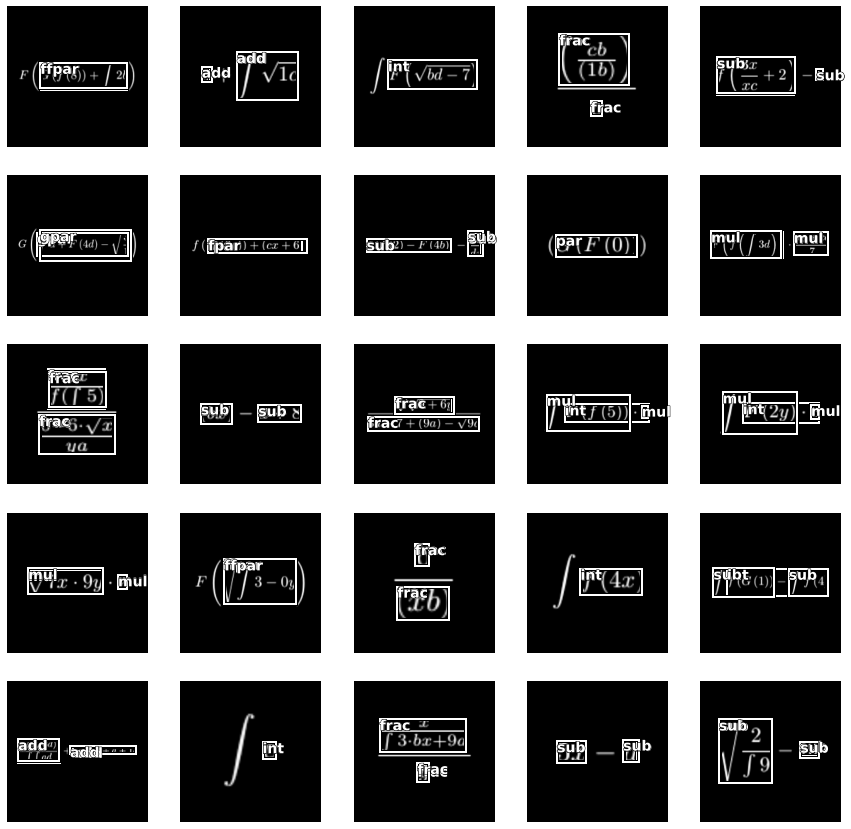

In [ ]:
learn.show_results(ds_idx=1, max_n=25)

In [ ]:
# bigger_cfg = cnn_config(n_in=1, custom_head=create_head(512, OUT, ps=0.25))

# learn = cnn_learner(dls, xse_resnext18_deeper, loss_func=ITLLoss(), pretrained=False, config=bigger_cfg,
#                     metrics=[ops_accuracy, boxes_iou])
# learn.fit_one_cycle(80, lr_max=0.008317)
# # learn.lr_find()
# # learn.summary()

epoch,train_loss,valid_loss,ops_accuracy,boxes_iou,time
0,11.990296,19.636063,0.151837,0.116051,00:26
1,8.907830,143.800964,0.155918,0.000000,00:26
2,7.665970,14.290667,0.089796,0.130522,00:26
3,6.755991,50.001911,0.166531,0.043372,00:26
4,6.078965,4.883886,0.553469,0.528393,00:26


In [ ]:
learn = cnn_learner(dls, resnet18, loss_func=ITLLoss(), pretrained=False, config=cfg,
                    metrics=[ops_accuracy, boxes_iou])
learn.fit_one_cycle(40)

epoch,train_loss,valid_loss,ops_accuracy,boxes_iou,time
0,7.552756,6.389969,0.346122,0.153867,00:25
1,5.515912,4.665903,0.447347,0.217006,00:24
2,3.619960,2.845216,0.520000,0.360682,00:24
3,2.722578,2.188705,0.553469,0.394568,00:24
4,2.296716,1.840845,0.586939,0.399697,00:24
5,2.016569,2.508117,0.668571,0.329100,00:24
6,1.611998,1.291160,0.794286,0.396937,00:24
7,1.335266,17.693068,0.188571,0.254026,00:24
8,1.147664,5.169071,0.457143,0.266028,00:24
9,0.982151,11.555217,0.189388,0.224225,00:24


In [ ]:
learn_xse = cnn_learner(dls, xse_resnext34, loss_func=ITLLoss(), pretrained=False, config=cfg,
                    metrics=[ops_accuracy, boxes_iou])
learn_xse.fit_one_cycle(60)

epoch,train_loss,valid_loss,ops_accuracy,boxes_iou,time
0,5.367112,4.162928,0.374694,0.245425,00:48
1,4.051618,3.550235,0.432653,0.304128,00:47
2,3.564545,3.021458,0.484082,0.355459,00:47
3,3.149375,3.034320,0.502857,0.370607,00:46
4,2.858692,2.679963,0.495510,0.429028,00:46
5,2.526666,2.015957,0.564898,0.441546,00:46
6,2.217757,1.960328,0.592653,0.425938,00:46
7,1.928084,1.986836,0.657143,0.405884,00:46
8,1.732186,2.939929,0.651429,0.314411,00:46
9,1.457412,1.336961,0.805714,0.423192,00:46


In [ ]:
learn_bigger = cnn_learner(dls, resnet34, loss_func=ITLLoss(), pretrained=False, config=cfg,
                    metrics=[ops_accuracy, boxes_iou])
learn_bigger.fit_one_cycle(60)
# learn_bigger.lr_find()

epoch,train_loss,valid_loss,ops_accuracy,boxes_iou,time
0,6.853040,6.103111,0.345306,0.225928,00:33
1,4.341351,4.554869,0.404898,0.360779,00:33
2,3.514239,3.046697,0.441633,0.388971,00:32
3,2.716266,2.169337,0.486531,0.482844,00:33
4,2.241279,1.875949,0.540408,0.477346,00:33
5,1.801830,1.626245,0.635918,0.484819,00:32
6,1.683892,2.000566,0.641633,0.466061,00:33
7,1.291930,2.451132,0.635102,0.411629,00:33
8,1.264523,1.698597,0.802449,0.488591,00:33
9,1.157380,2.915133,0.693878,0.383307,00:33


In [ ]:
learn = cnn_learner(dls, resnet18, loss_func=ITLLoss(), pretrained=False, config=cfg,
                    metrics=[ops_accuracy, boxes_iou])
learn.fit_one_cycle(50)

epoch,train_loss,valid_loss,ops_accuracy,boxes_iou,time
0,6.274313,5.172562,0.344490,0.214965,00:24
1,4.061436,3.507989,0.420408,0.328323,00:24
2,3.474292,3.325428,0.480000,0.368099,00:24
3,2.905535,2.985737,0.497959,0.293885,00:24
4,2.381976,1.616688,0.564898,0.522279,00:24
5,2.021041,1.957361,0.622041,0.417535,00:24
6,1.614136,10.965813,0.347755,0.107360,00:24
7,1.395821,2.259710,0.760000,0.389594,00:24
8,1.192856,15.324406,0.199184,0.226770,00:24
9,1.067674,15.523710,0.228571,0.163400,00:24


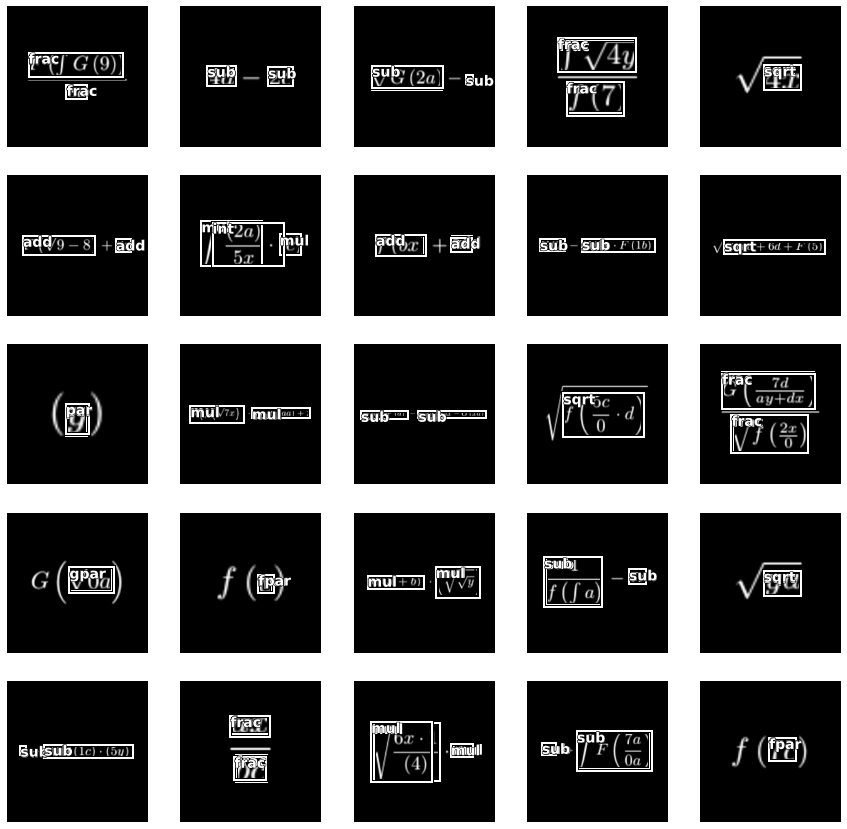

In [ ]:
learn_bigger.show_results(max_n=25)

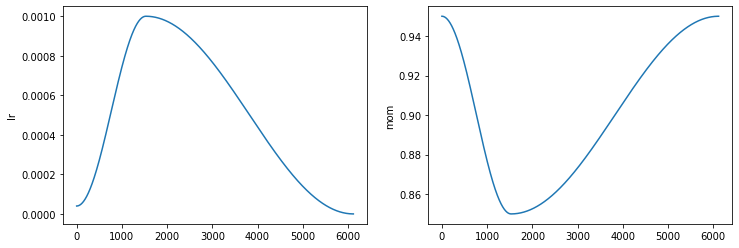

In [ ]:
learn.recorder.plot_sched()

In [ ]:
learn.summary()

Sequential (Input shape: ['32 x 1 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               32 x 64 x 112 x 112  3,136      True      
________________________________________________________________
BatchNorm2d          32 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 32 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            32 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               32 x 64 x 56 x 56    36,864     True      
________________________________________________________________
BatchNorm2d          32 x 64 x 56 x 56    128        True      
________________________________________________________________
ReLU                 32 x 64 x 56 x 56    0          False     
_________________________________________________